## MVP Modeling

START WITH CLASSIFICATION. Binary classification is simplest modeling goal. If you can't predict whether or not a ZCTA has PV at all, you won't be able to predict how much it actually has. 
    - Predict whether or not a ZCTA has any residential PV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering

In [27]:
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('../data/data1.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
df.head()

,zcta,state_code,average_household_income,mean_household_income_lowest_quintile,mean_household_income_second_quintile,mean_household_income_third_quintile,mean_household_income_fourth_quintile,mean_household_income_highest_quintile,mean_household_income_top_5_percent,education_bachelor,...,earth_temp,frost_days,earth_temp_amplitude,solar_azimuth_angle,num_systems,total_capacity,mean_system_size,median_system_size,num_incentives,num_policies
0,85610,4,22618.954248,15735.0,28976.0,41584.0,60403.0,121871.0,186273.0,56,...,17.40,3.3,18.02,-100.64,13.0,70.150,5.396154,5.3800,17,12
1,85614,4,37116.351937,15092.0,33942.0,52059.0,78902.0,156740.0,271955.0,5034,...,20.51,0.8,18.44,-101.18,1012.0,7015.507,6.932319,5.9850,17,12
2,85624,4,23497.905353,12085.0,26596.0,40793.0,63481.0,139590.0,195939.0,226,...,20.51,0.8,18.44,-101.18,24.0,150.860,6.285833,5.8650,17,12
3,85629,4,30438.482732,24218.0,55100.0,82356.0,109225.0,187332.0,290584.0,3482,...,20.51,0.8,18.44,-101.18,1186.0,8934.678,7.533455,7.2975,17,12
4,85630,4,30497.211155,6123.0,16639.0,37332.0,58660.0,167178.0,298053.0,189,...,17.40,3.3,18.02,-100.64,37.0,258.010,6.973243,6.4800,17,12


Target is going to be `solar_density` which is the total capacity (kW) per 1,000 households in the ZCTA (`total_capacity` / (`household_count` / 1000)). Need to check `household_count` column for ZCTAs with no households

In [3]:
df['household_count'].isna().sum()

0

No official missing values

In [4]:
df.loc[df['household_count'] <= 0]

,zcta,state_code,average_household_income,mean_household_income_lowest_quintile,mean_household_income_second_quintile,mean_household_income_third_quintile,mean_household_income_fourth_quintile,mean_household_income_highest_quintile,mean_household_income_top_5_percent,education_bachelor,...,earth_temp,frost_days,earth_temp_amplitude,solar_azimuth_angle,num_systems,total_capacity,mean_system_size,median_system_size,num_incentives,num_policies
14,85341,4,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,0,...,23.49,0.17,18.25,-102.28,NaN,NaN,NaN,NaN,17,12
31,85723,4,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,0,...,20.51,0.80,18.44,-101.18,1.0,2917.59,2917.59,2917.59,17,12
32,85724,4,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,0,...,20.51,0.80,18.44,-101.18,NaN,NaN,NaN,NaN,17,12
33,85726,4,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,0,...,20.51,0.80,18.44,-101.18,NaN,NaN,NaN,NaN,17,12
105,85535,4,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,0,...,16.91,3.42,17.76,-100.92,NaN,NaN,NaN,NaN,17,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15057,53192,55,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,0,...,8.31,11.58,14.03,-88.99,NaN,NaN,NaN,NaN,18,6
15200,53031,55,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,0,...,7.71,12.04,12.76,-88.96,NaN,NaN,NaN,NaN,18,6
15260,53792,55,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,0,...,8.23,11.95,14.99,-89.64,NaN,NaN,NaN,NaN,18,5
15456,54561,55,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,0,...,4.32,14.49,14.30,-90.28,NaN,NaN,NaN,NaN,18,6


192 ZCTAs where `household_count` is 0. Looks like all census data is missing from those ZCTAs. Drop these rows.

In [5]:
df = df.loc[df['household_count'] > 0]

**SIDE NOTE**: Model predicting `total_installed_price` from original PV data??

Create `solar_density` column

In [6]:
df['solar_density'] = df['total_capacity'] / (df['household_count'] / 1000)

In [7]:
df['solar_density'].isna().sum()

6184

In [8]:
df.shape

(15548, 105)

6,184 of the 15,548 ZCTAs do not have solar. Create new column, `has_solar` indicating this. First, I replace missing values in `solar_density` with 0

In [22]:
df['solar_density'] = df['solar_density'].replace({np.nan: 0})

In [25]:
df['has_solar'] = df['solar_density'].apply(lambda x: 1 if x > 0 else 0)
df['has_solar'].value_counts()

1    9364
0    6184
Name: has_solar, dtype: int64

## Classification Modeling

I will begin by predicting whether or not a ZCTA has any residential PV

### EDA

<AxesSubplot:xlabel='has_solar', ylabel='num_incentives'>

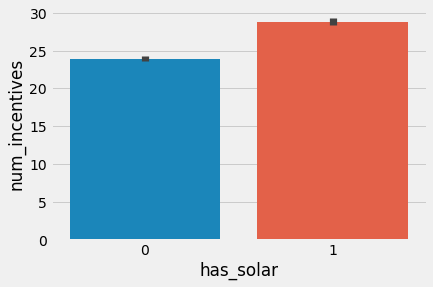

In [28]:
sns.barplot(x='has_solar', y='num_incentives', data=df)

The biggest problem with my current incentives and policies features are that the majority are state funded. Meaning they apply to all ZCTAs in state and there are a lot of other influencing factors at the ZCTA level. I want to get the DSIRE data into a SQL database so I can query it whenever I need to rather than use the DataFrames.

I really just want to practice and mess around with the data I have here. I don't care if a full, cohesive project comes out of it. It's data that interests me and I just want to get into it. 

That being said, do actual statistical analysis. Just analyze the data. Ask a bunch of different questions and start diving into it.

In [80]:
df.loc[df['average_household_income'] <= 0]['has_solar'].value_counts()

0    104
1     14
Name: has_solar, dtype: int64

118 ZCTAs are missing income data. 104 of these have no solar deployment.

I think an important feature may be the utility and/or balancing authority territory a ZCTA falls within. Pretty important for PV

/Users/mattcarr/opt/anaconda3/envs/pv-analysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


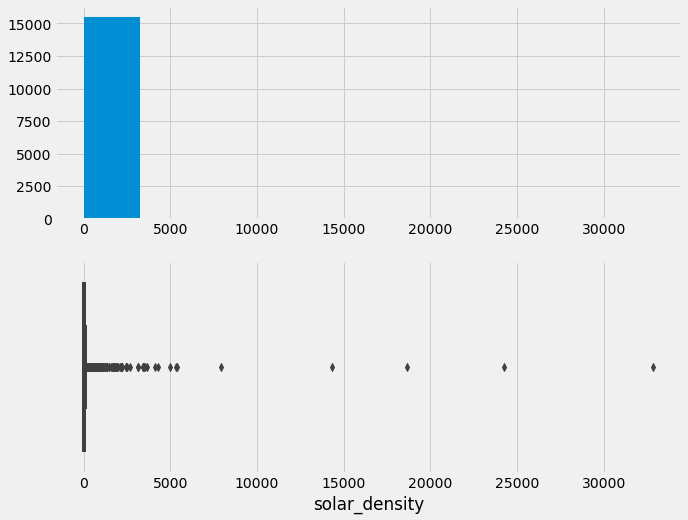

In [85]:
fig, ax = plt.subplots(nrows=2, figsize=(10,8))
ax[0].hist(df['solar_density'])
sns.boxplot(df['solar_density'], ax=ax[1]);

This includes all of the ZCTAs with no PV. I want to look at the extreme outliers, any ZCTA with a `solar_density` above 5,000

In [86]:
solar_outliers = df.loc[df['solar_density'] >= 5000]
solar_outliers.shape

(7, 106)

In [87]:
solar_outliers

,zcta,state_code,average_household_income,mean_household_income_lowest_quintile,mean_household_income_second_quintile,mean_household_income_third_quintile,mean_household_income_fourth_quintile,mean_household_income_highest_quintile,mean_household_income_top_5_percent,education_bachelor,...,earth_temp_amplitude,solar_azimuth_angle,num_systems,total_capacity,mean_system_size,median_system_size,num_incentives,num_policies,solar_density,has_solar
30,85707,4,-9.832842e+05,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,12,...,18.44,-101.18,7.0,16445.555,2349.365000,4.950,17,12,24255.980826,1
143,85633,4,9.829268e+03,NaN,NaN,NaN,NaN,NaN,NaN,12,...,18.57,-101.73,2.0,588.120,294.060000,294.060,17,12,14344.390244,1
4952,2651,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,...,2.56,-77.23,65.0,466.837,7.182108,6.600,29,4,18673.480000,1
5827,8095,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,13.85,-81.00,19.0,208.130,10.954211,11.000,11,7,5336.666667,1
6019,7820,34,-8.333333e+07,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,2,...,13.70,-80.79,3.0,42.940,14.313333,14.640,11,7,5367.500000,1
7029,11931,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,...,6.83,-79.49,35.0,309.450,8.841429,8.500,21,7,7934.615385,1
13956,84335,49,2.280627e+04,26116.0,51215.0,69838.0,95075.0,161766.0,263390.0,1880,...,17.45,-104.74,154.0,434636.515,2822.315032,5.575,13,11,32844.896471,1


The solar data for these 7 ZCTAs is interesting. 85707 and 84335 both have a relatively high `mean_system_size` but extremely low `median_system_size` this tells me there was probably 1-2 extremely large systems. 84335 has 154 systems, so it makes sense that `total_capacity` is high. My first thought is most of these have low household count

In [88]:
solar_outliers['household_count']

30         678
143         41
4952        25
5827        39
6019         8
7029        39
13956    13233
Name: household_count, dtype: int64

In [89]:
solar_outliers['total_population']

30         678
143         41
4952        25
5827        39
6019         8
7029        39
13956    13233
Name: total_population, dtype: int64

84335 comes across as a valid value. 154 systems totalling to a large `total_capacity` across 13,000 homes. Due to my calculation of `solar_density` the value comes out extremely large. It is large for the other 6 ZCTAs as well but more due to extremely low `household_count` and likely a few very relatively large PV systems. All of the ZCTAs other than 84335 are missing income data as well.

Interesting that the `household_count` for all of these ZCTAs is same as `total_population`. Wondering now if that is a larger problem.

In [90]:
df[['household_count', 'total_population']]

,household_count,total_population
0,1071,1071
1,23777,23777
2,1289,1289
3,25770,25770
4,1757,1757
...,...,...
15735,380,380
15736,1555,1555
15737,1233,1233
15738,394,394


This does not seem right. Looks like `total_population` and `household_count` values are the same.

In [95]:
(df['household_count'] != df['total_population']).sum()

0

This is true for every ZCTA. I want to check a few of the other housing columns to see if they may be a better fit. Either `total_population` or `household_count` is wrong.

In [98]:
[col for col in df.columns if 'hous' in col]

['average_household_income',
 'mean_household_income_lowest_quintile',
 'mean_household_income_second_quintile',
 'mean_household_income_third_quintile',
 'mean_household_income_fourth_quintile',
 'mean_household_income_highest_quintile',
 'mean_household_income_top_5_percent',
 'heating_fuel_housing_unit_count',
 'median_household_income',
 'household_count',
 'housing_unit_count',
 'housing_unit_occupied_count',
 'housing_unit_median_value',
 'housing_unit_median_gross_rent']

In [99]:
df[['household_count', 'housing_unit_count', 'housing_unit_occupied_count', 'total_population']]

,household_count,housing_unit_count,housing_unit_occupied_count,total_population
0,1071,691,451,1071
1,23777,16986,13104,23777
2,1289,860,536,1289
3,25770,9260,8559,25770
4,1757,1226,937,1757
...,...,...,...,...
15735,380,315,165,380
15736,1555,1683,778,1555
15737,1233,1539,536,1233
15738,394,386,195,394


After reviewing my collection of census data and researching my variables on [Census Data search tool](https://data.census.gov/cedsci/table?q=Housing%20Units&d=ACS%205-Year%20Estimates%20Detailed%20Tables&tid=ACSDT5Y2020.B25001), I realize the data I collected for `household_count` was really the number of people living in certain types of households, so it was another form of population count. 

The original census variable I used for `household_count` was `B09019_001E`. After exploring the search tool above some more, I think `B11012` would be a more better `household_count` metric. I will need to go back and recollect my Census data (which I want to do anyways so I can use the 2020 5-year ACS instead of the 2019 5-year ACS). I think `housing_unit_count` may be a better metric anyways. [This definition guide](https://www.census.gov/housing/hvs/definitions.pdf) outlines what a housing unit it and it seems to follow the definition I am looking for.